# Some example and steps of using Maximum likelihood based Brandt's Generalized Likelihood Ratio (GLR) in change detection



In [4]:
import numpy as np
import matplotlib.pyplot as plt


In [15]:
# Construct my example signals
# This signal has very obvious changing means, but not so much to signal variance
sample_sig2 = np.zeros(1000)
my_time = np.arange(1000)
sample_sig2 = np.sin(my_time)
sample_sig2[200:300] = 2*np.sin(my_time[200:300]) + 10
sample_sig2[400:500] = 1.5*np.sin(my_time[400:500])
sample_sig2[450:550] = 2*np.sin(my_time[450:550]) + 7.5
sample_sig2[750:850] = np.sin(my_time[750:850]) - 6
my_signal = sample_sig2

Text(0.5,0,'time points')

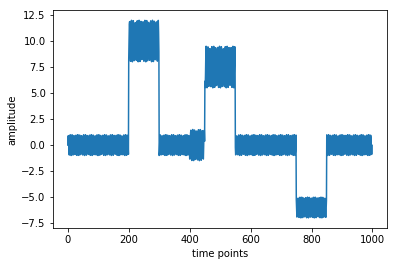

In [16]:
# plot the signal just to see what it looks like
plt.figure()
plt.plot(my_signal)
plt.ylabel('amplitude')
plt.xlabel('time points')

In [17]:
#%% Maximum likelihood based change prediction research
# Generate the statistics for Maximum likelihood based Generalized Likelihood Ratio (GLR) algorithm
#    Refer to text book "Adaptive Filtering and Change Detection" page 70 to 80


# ------------------------------ Model 1-----------------------------
# ********************************* ... *****************************   assume this line is my signal
# t0                                    ------------ model 2---------
# t0, latest detected change time       <--------length of L-------->
#          

def GetMyStatistics(y, L, t0, method=0):
    
    '''
    Given the signal, calculate those parameters needed to derive the 
    test statistics for a LR based change detection algorithm.
    y, the input signal
    L, the break point for the time window, for an offline problem, that is where to break the signal into to segments     
    t0, the lateset detected changing time point
    
    method, how you want to calculate the variance of a given section of signal
    0, use an estimated equiation to calculate, refer to text book page 80
    1, calculate using the definition, refer to text book page 79.    
    '''
    # if signal starts from 0, then t0=0     
    t  = len(y)  # the last time point, the length of the signal
  
    # Refer to text book "Adaptive Filtering and Change Detection" page 79
    # also, I believe that the authors make the wrong equation for thetat_2 and Rt_2
    # The model M2 on page 78 has a length of L, it is from t-l+1 to t, 
    # while the author somehow using L+1 to t, which was wrong. 
    if method == 1:
        thetat_1 = np.sum(y[t0+1:t])/(t-t0) # mean value of signal for model 1
        thetat_2 = np.sum(y[t-L+1:t]) /(L)  # mean value of signal for model 2
        Rt_1  = np.sum(  (y[t0+1:t]-thetat_1)**2  ) /(t-t0) # signal variance for model 1
        Rt_2  = np.sum(  (y[t-L+1:t] -thetat_2)**2  ) /(L)  # signal variance for model 2

    # using a different equation to estimation the variance
    # Refer to text book "Adaptive Filtering and Change Detection" page 80
    if method ==0:
        Rt_1 = y[t0+1:t].dot(y[t0+1:t])/(t-t0) - (np.sum(y[t0+1:t])/(t-t0))**2
        Rt_2 = y[t-L+1:t].dot(y[t-L+1:t])/(L) - (np.sum(y[t-L+1:t])/(L))**2

    epsilont_1 = y[-1] - np.sum(y[t0+1:t-1])/(t-1-t0) # theta_1(t-1)
    epsilont_2 = y[-1] - np.sum(y[t-L+1:t-1]) /(L-1)  # theta_2(t-1)

    return (Rt_1, Rt_2, epsilont_1, epsilont_2)

(-40, 40)

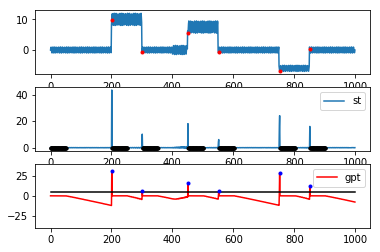

In [18]:
import numpy as np
'''
Refer to text book "Adaptive Filtering and Change Detection" page 70 to 80,
Brandt's GLR
'''
# adjusting the window size L, could affecting the performance of change detection
# Adjust threshold h within a range, not affect the results to much, but if h is way too off, the 
# results will be affected.
# One should do some experiments to test what appropriate h and L is suitable for your data sets.
h,  L      = 5, 50           # the threshold, and window size to calculate the ML, and time window to include the signal
gpt, t0, v = 0, 0, 0.03       # intialize the test statistics and drifting parameter
tap = np.array([], dtype=int) # initialize the vector to store possbile change time
st_list,gpt_list = [], [] # distance measure from observation to observation and positive test statistics

for n in range(len(my_signal)):  
    # from current change time to now, 
    # if there is not enough data points to fullfill the length of the required time window
    if (n-t0)<=L+1:   # due to the definition of epsilon (in GetMyStatistics()), here n needs to be bigger than L+1
        st_list.append(0)
        gpt_list.append(gpt)
        continue   # return to next for loop, no execution of the code below

    # after the initial time window of L+1, when there is change detected
    # the time point right after the detected change, there is no change

    y = my_signal[0:n]   # get the signal that is defined by the time window, also after updated t0
    # in this function, only consider the signal between last change time t0 to now
    (Rt_1, Rt_2, epsilont_1, epsilont_2) = GetMyStatistics(y, L, t0, method=1)

    if Rt_1==0 or Rt_2==0: st = 0 # in this case, the input signal is just flat, no change at all   
    else:  st = np.log(Rt_1/Rt_2) + epsilont_1**2/Rt_1 - epsilont_2**2/Rt_2

    if np.isnan(st): # just to check when there is nan, and break the code if there is        
        print(n)     # not necessary for algorithm implementation
        break

    gpt = gpt + st -v   # update the testing statistics with the newest Likihood Ratio based distance
    st_list.append(st)
    gpt_list.append(gpt)
    
    # when a change is detected, reset the test statistics, the change time, and record the change time
    if gpt>h : 
        gpt, t0 = 0, n  # reset the testing statistics and record the change time           
        tap = np.append(tap, n)


plt.figure() # plot raw signal, with its detected change time
plt.subplot(3,1,1)
plt.plot(my_signal)
plt.plot(tap, my_signal[tap], '.', color='r')

plt.subplot(3,1,2)  # plot the measured LR distance from observation to observation
plt.plot(np.arange(len(my_signal)), np.asarray(st_list, dtype=float))
zeros_index = np.where(np.asarray(st_list)==0)[0] # when the data is not long enough to match window L, st=0
plt.plot(zeros_index, np.asarray(st_list, dtype=float)[zeros_index], 'k.') # show those values in black
plt.legend(['st'])

plt.subplot(3,1,3) # plot the test statistics along with the detecting threshold
plt.plot(np.arange(len(my_signal)), np.asarray(gpt_list, dtype=float), color='r')
plt.plot(np.ones_like(gpt_list)*h, color='k')
plt.plot(tap, np.asarray(gpt_list)[tap], '.', color='b')
plt.legend(['gpt'])
plt.ylim([-8*h, 8*h])

#plt.plot(np.zeros_like(np.asarray(st_list, dtype=float)))

